## Sentiment Analysis with Tweepy

### Set up environment

In [2]:
import tweepy
import pandas as pd
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')

import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\MTL9\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Twitter Authentication

In [6]:
#Put your Bearer Token in the parenthesis below
client = tweepy.Client(bearer_token='----------------------')

### Get recent public tweets on a keyword

#### Steps breakdown
* Pull tweets with the hashtag Ghana without retweets, which are in english.
* paginator method to allow us make multiple calls
* i get 100 tweets times 10 to get 1000 tweets

In [3]:
# Pull tweets from twitter

query = '#ghana -is:retweet lang:en' # tweets without retweets with the hashtag ghana
paginator = tweepy.Paginator(
    client.search_recent_tweets,           # The method you want to use
    query=query,                           # Some argument for this method
    max_results=100,                       # How many tweets per page
    limit=10                              # How many pages to retrieve
)

tweet_list = []

for tweet in paginator.flatten(): # Total number of tweets to retrieve
    tweet_list.append(tweet)

NameError: name 'client' is not defined

In [34]:
#Creating new dataframe and new features
tweet_list_df = pd.DataFrame(tweet_list)
tweet_list_df = pd.DataFrame(tweet_list_df['text'])
tweet_list_df.head(5)

,text
0,Ghana's coach was really worried about Son Heu...
1,Ghana's coach was really worried about Son Heu...
2,"@FrankKhalidUK If it's about being old, then G..."
3,15 SMEs in Ghana receive GH¢2.3 million fundin...
4,"Jamestown Lighthouse, Accra \n#Cloud #Lighthou..."


### Data preprocessing
**Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase**
* all words in lower case
* remove rt
* remove special characters
* remove single characters
* remove multiple spaces

In [35]:
def preprocess_tweet(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()
    # Remove RT
    sentence = re.sub('RT @\w+: '," ", sentence)
    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    return sentence

In [36]:
cleaned_tweets = []

for tweet in tweet_list_df['text']:
  cleaned_tweet = preprocess_tweet(tweet)
  cleaned_tweets.append(cleaned_tweet)

In [37]:
tweet_list_df['cleaned'] = pd.DataFrame(cleaned_tweets)
tweet_list_df.head(5)

,text,cleaned
0,Ghana's coach was really worried about Son Heu...,ghana coach was really worried about son heung...
1,Ghana's coach was really worried about Son Heu...,ghana coach was really worried about son heung...
2,"@FrankKhalidUK If it's about being old, then G...",if it about being old then ghana should be wi...
3,15 SMEs in Ghana receive GH¢2.3 million fundin...,15 smes in ghana receive gh 2 3 million fundin...
4,"Jamestown Lighthouse, Accra \n#Cloud #Lighthou...",jamestown lighthouse accra cloud lighthouse gu...


### Generate Sentiment Labels

In [38]:
#Calculating Negative, Positive, Neutral and Compound values

tweet_list_df[['polarity', 'subjectivity']] = tweet_list_df['cleaned'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweet_list_df['cleaned'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if comp <= -0.05:
        tweet_list_df.loc[index, 'sentiment'] = "negative"
    elif comp >= 0.05:
        tweet_list_df.loc[index, 'sentiment'] = "positive"
    else:
        tweet_list_df.loc[index, 'sentiment'] = "neutral"
    tweet_list_df.loc[index, 'neg'] = neg
    tweet_list_df.loc[index, 'neu'] = neu
    tweet_list_df.loc[index, 'pos'] = pos
    tweet_list_df.loc[index, 'compound'] = comp

tweet_list_df.head(5)
tweet_list_df.to_csv('tweet_list_df.csv')

### Sentiment Visualisation

In [39]:
#Creating new data frames for all sentiments (positive, negative and neutral)

tweet_list_df_negative = tweet_list_df[tweet_list_df["sentiment"]=="negative"]
tweet_list_df_positive = tweet_list_df[tweet_list_df["sentiment"]=="positive"]
tweet_list_df_neutral = tweet_list_df[tweet_list_df["sentiment"]=="neutral"]

#### Pie Charts

In [40]:
#Function for count_values_in single columns

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [41]:
#Count_values for sentiment
count_values_in_column(tweet_list_df,"sentiment")

,Total,Percentage
positive,542,54.31
neutral,304,30.46
negative,152,15.23


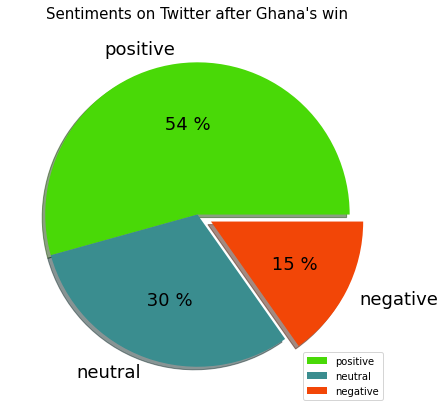

In [92]:
plt.figure(figsize=(7,7))
# create data for Pie Chart
pichart = count_values_in_column(tweet_list_df,"sentiment")

names= pichart.index
size=pichart["Percentage"]
cr =['#49D907','#3A8D8F','#F24607']
explode=[0,0,.1]
plt.pie(size, labels=names, colors=cr,autopct='% .0f %%',explode=explode,textprops={'fontsize':18},shadow=True)
plt.title("Sentiments on Twitter after Ghana's win",fontsize=15)
plt.legend()
plt.savefig('sentiments_Ghana.png')
plt.show()

## Insights
**54%** of what people are tweeting about Ghana is positive is very impresssive. <br>Because for the past weeks and months the sentiments has always been negative.<br>
**30%** of the tweets were neutral<br>
**15%** were negative.<br>

The wordclouds will give us a preview of what words they saying.

#### Word Clouds

In [84]:
#Function to Create Wordcloud

def create_wordcloud(text):
    mask = np.array(Image.open("wcup.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color='white',
                  mask = mask,
                  max_words=500,
                  stopwords=stopwords,
                  repeat=True)
    wc.generate(str(text))
    wc.to_file("c1_wordcloud.png")
    print("Word Cloud Saved Successfully")
    path="c1_wordcloud.png"
    display(Image.open(path))

Word Cloud Saved Successfully


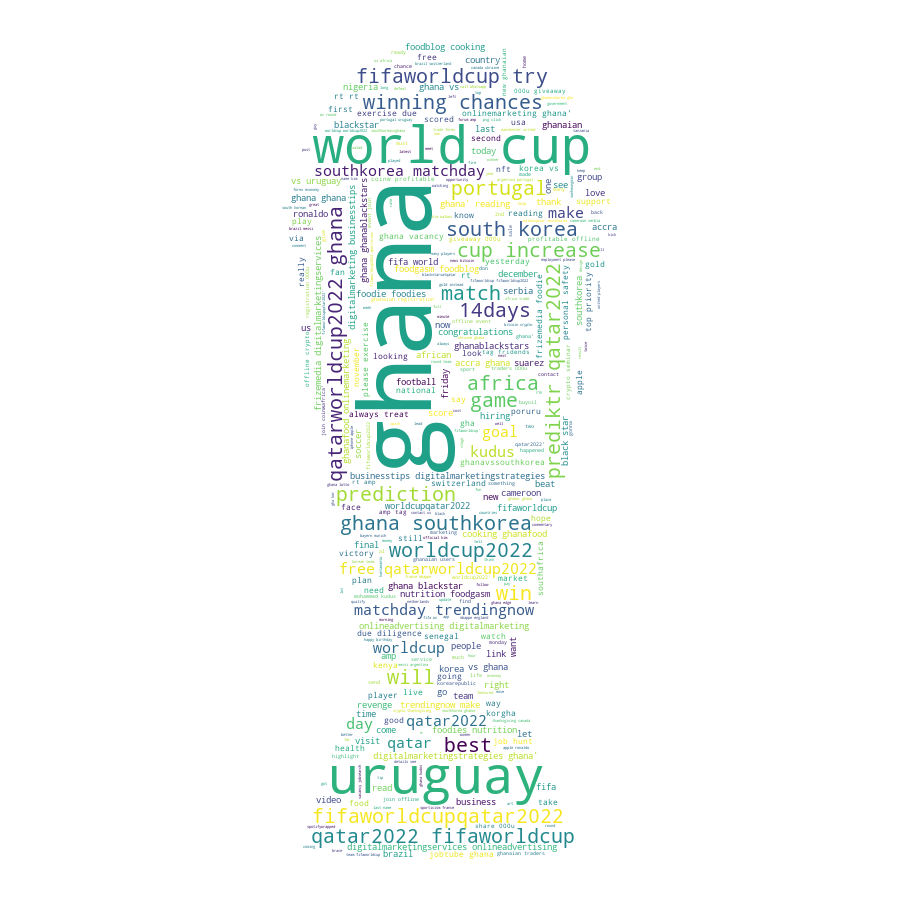

In [85]:
# Creating wordcloud for all tweets

create_wordcloud(tweet_list_df["cleaned"].values)

## Insights from full tweets
**Dorminant words in the Tweets**
* ghana
* uruguay
* south korea
* best
* kudus
* win
* portugal

Word Cloud Saved Successfully


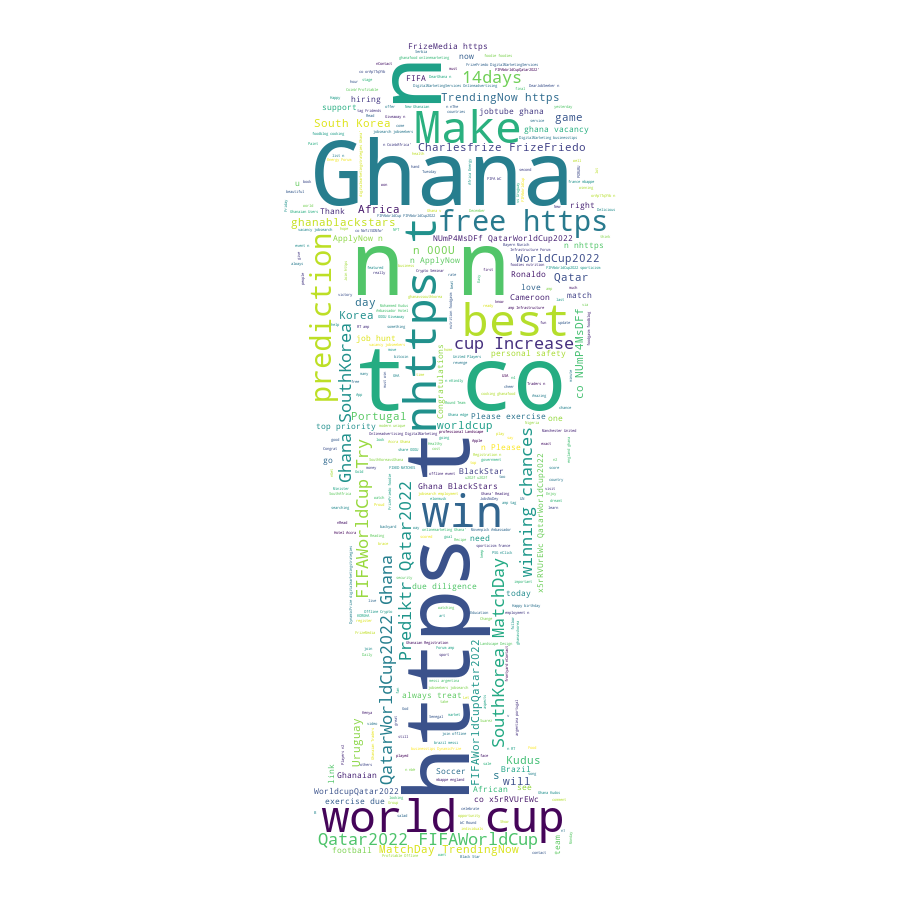

In [117]:
create_wordcloud(tweet_list_df_positive["text"].values)

## Insights from the positive Tweets
**Dorminant words here**
* win
* worldcup
* kudus
* ghana

Word Cloud Saved Successfully


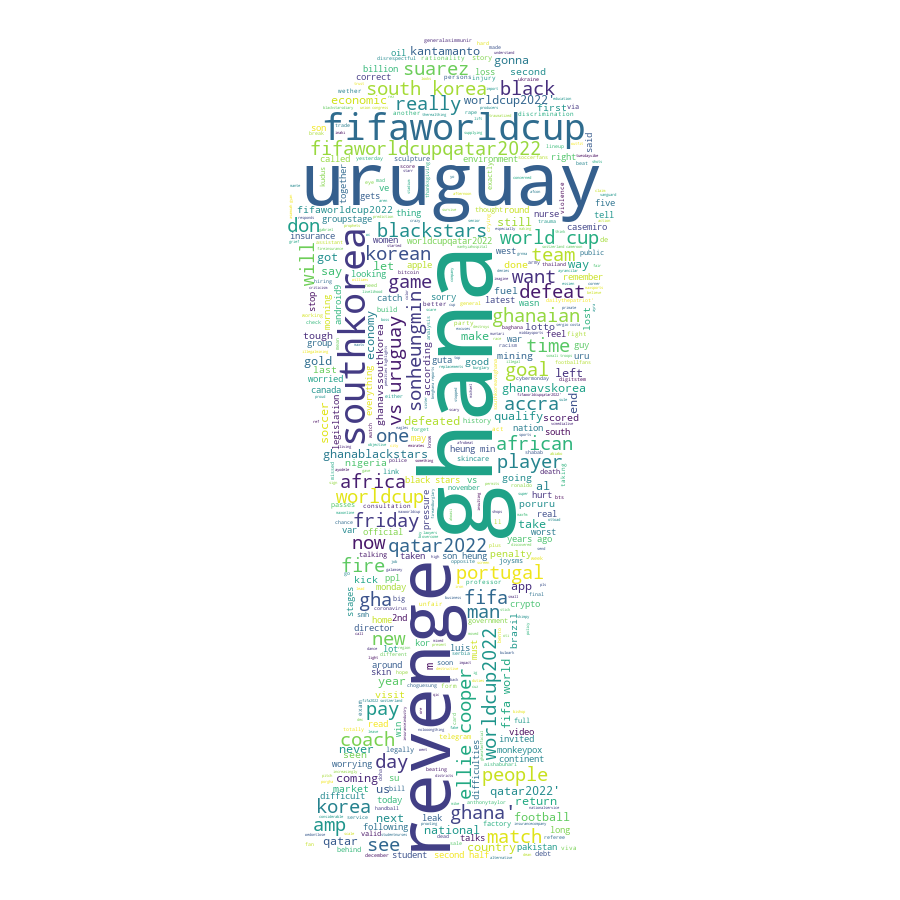

In [116]:
create_wordcloud(tweet_list_df_negative["cleaned"].values)

## Insights from Negative Tweets
**Dorminant Tweets**
* revenge:    not suprised as our next match is against Uruguay
* friday
* south korea
* ghana
* defeat
* coach
* black stars


Word Cloud Saved Successfully


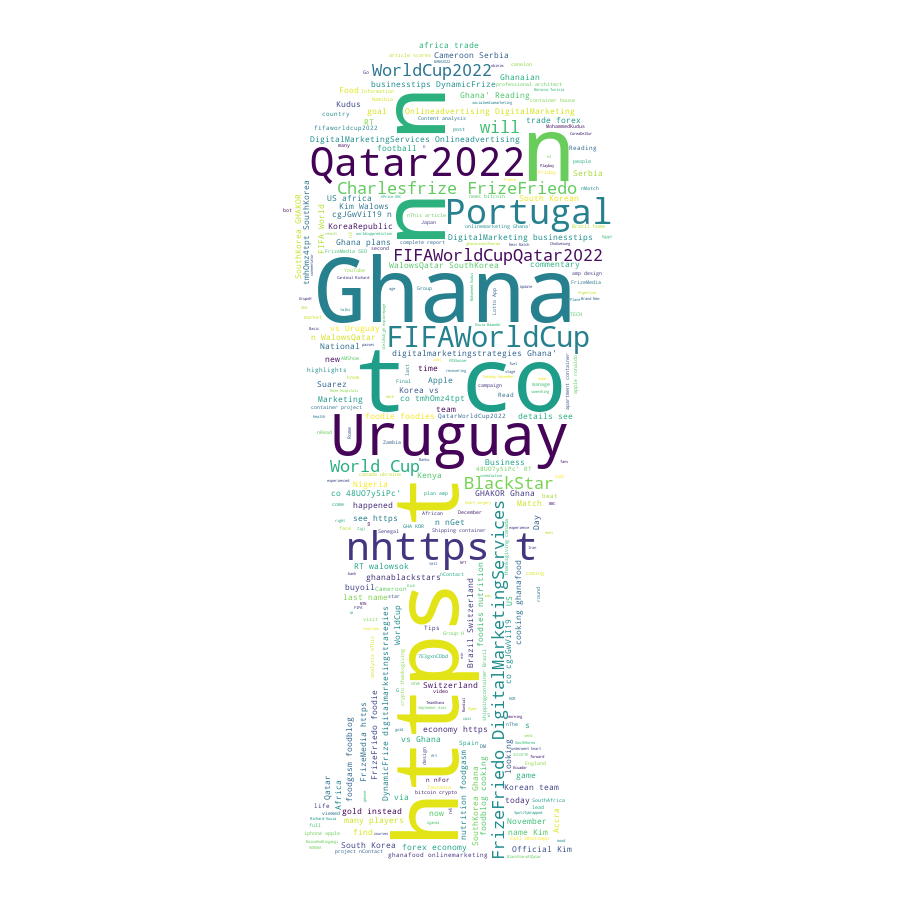

In [115]:
create_wordcloud(tweet_list_df_neutral["text"].values)

## Insights from Neutral Tweets
**Dorminant Tweets**
* https
* uruguay
* blackstar
* worldcup
* Qatar2022

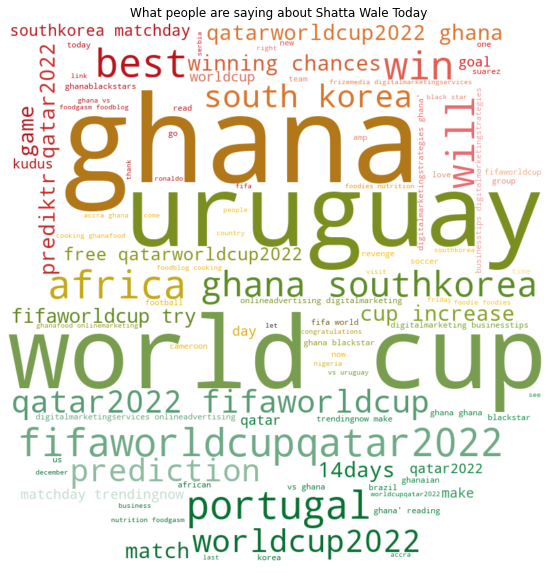

In [49]:

stopwords = set(STOPWORDS)
wc = WordCloud(background_color='white',mask = mask,max_words=100,stopwords=stopwords,repeat=True)
wc.generate(str(tweet_list_df["cleaned"].values))
img_col=ImageColorGenerator(mask)
plt.figure(figsize=(10,10))
plt.imshow(wc.recolor(color_func=img_col),interpolation='bilinear')
plt.axis('off')
plt.title("What people are saying about Shatta Wale Today")
plt.savefig('shatta.png',format='png');

Word Cloud Saved Successfully


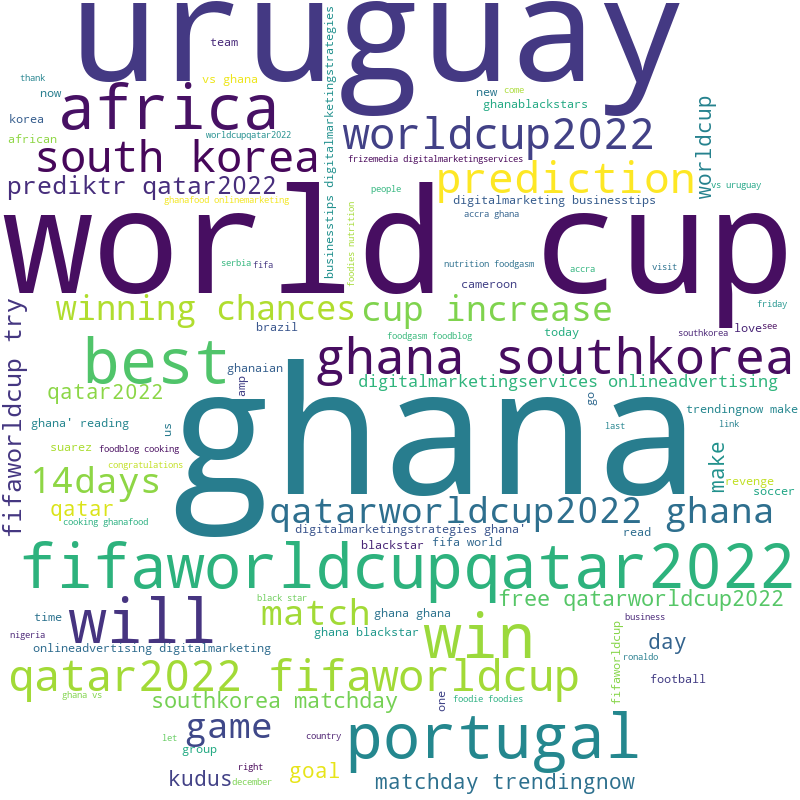

In [50]:
#mask = np.array(Image.open("cloud.png"))
stopwords = set(STOPWORDS)
wc = WordCloud(background_color='white',mask = mask,max_words=100,stopwords=stopwords,repeat=True)
wc.generate(str(tweet_list_df["cleaned"].values))
wc.to_file("c1_wordcloud.png")
print("Word Cloud Saved Successfully")
path="c1_wordcloud.png"
display(Image.open(path))

#### Text Insights

In [51]:
#Calculating tweet's lenght and word count
tweet_list_df['text_len'] = tweet_list_df['cleaned'].astype(str).apply(len)
tweet_list_df['text_word_count'] = tweet_list_df['cleaned'].apply(lambda x: len(str(x).split()))

In [52]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,143.85
neutral,130.75
positive,170.31


In [53]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,22.88
neutral,18.69
positive,25.34


### Saving Output Tweets File to Drive

In [55]:
tweet_list_df.to_csv("ghana_sentimentanalysis.csv", sep=',', encoding='UTF-8')
tweet_list_df.head(5)

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count
0,Ghana's coach was really worried about Son Heu...,ghana coach was really worried about son heung...,0.200000,0.200000,negative,0.214,0.786,0.00,-0.5984,129,20
1,Ghana's coach was really worried about Son Heu...,ghana coach was really worried about son heung...,0.200000,0.250000,negative,0.175,0.825,0.00,-0.5984,136,25
2,"@FrankKhalidUK If it's about being old, then G...",if it about being old then ghana should be wi...,0.158333,0.441667,positive,0.000,0.880,0.12,0.5267,169,26
3,15 SMEs in Ghana receive GH¢2.3 million fundin...,15 smes in ghana receive gh 2 3 million fundin...,0.000000,0.000000,neutral,0.000,1.000,0.00,0.0000,53,11
4,"Jamestown Lighthouse, Accra \n#Cloud #Lighthou...",jamestown lighthouse accra cloud lighthouse gu...,0.850000,1.000000,positive,0.000,0.830,0.17,0.5994,170,20


## Sentiments Dashboard

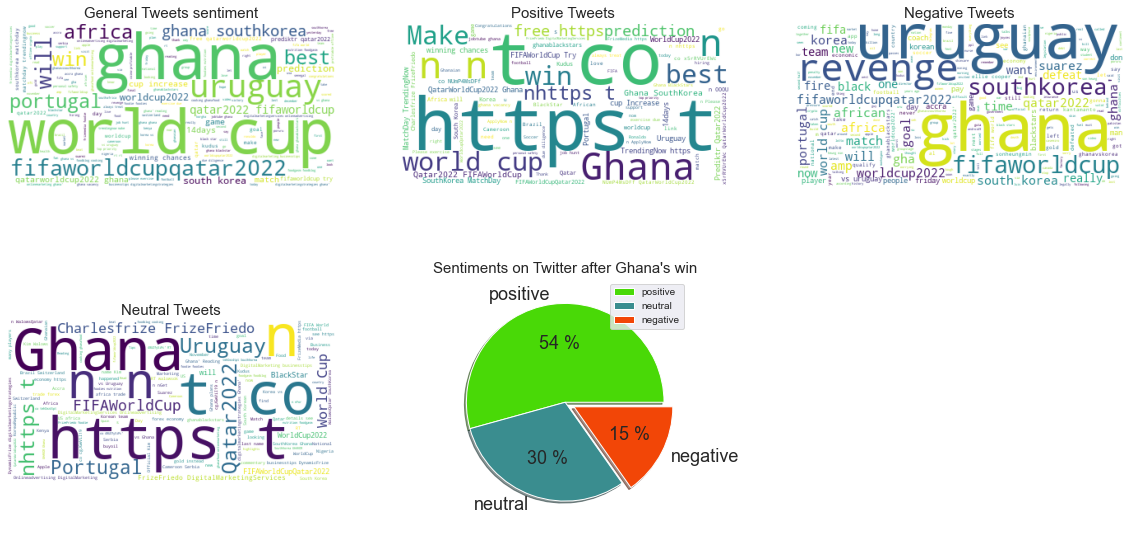

<Figure size 432x288 with 0 Axes>

In [121]:
# First plot
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.title('General Tweets sentiment',fontsize=15)
stopwords = set(STOPWORDS)
wc = WordCloud(background_color='white',max_words=300,stopwords=stopwords,repeat=True)
wc.generate(str(tweet_list_df["cleaned"].values))
wc.to_file("c1_wordcloud.png")
plt.axis('off')
plt.imshow(wc,interpolation='bilinear')

# second plot
plt.subplot(2,3,2)
plt.title('Positive Tweets ',fontsize=15)
stopwords = set(STOPWORDS)
wc = WordCloud(background_color='white',max_words=300,stopwords=stopwords,repeat=True)
wc.generate(str(tweet_list_df_positive["text"].values))
wc.to_file("c1_wordcloud.png")
plt.axis('off')
plt.imshow(wc)

# third plot
plt.subplot(2,3,3)
plt.title('Negative Tweets',fontsize=15)
stopwords = set(STOPWORDS)
wc = WordCloud(background_color='white',max_words=300,stopwords=stopwords,repeat=True)
wc.generate(str(tweet_list_df_negative["cleaned"].values))
wc.to_file("c1_wordcloud.png")
plt.axis('off')
plt.imshow(wc)

# fourth plot
plt.subplot(2,3,4)
plt.title('Neutral Tweets',fontsize=15)
stopwords = set(STOPWORDS)
wc = WordCloud(background_color='white',max_words=300,stopwords=stopwords,repeat=True)
wc.generate(str(tweet_list_df_neutral["text"].values))
wc.to_file("c1_wordcloud.png")
plt.axis('off')
plt.imshow(wc)

# fifth plot
plt.subplot(2,3,5)
# create data for Pie Chart
pichart = count_values_in_column(tweet_list_df,"sentiment")
names= pichart.index
size=pichart["Percentage"]
cr =['#49D907','#3A8D8F','#F24607']
explode=[0,0,.1]
plt.pie(size, labels=names, colors=cr,autopct='% .0f %%',explode=explode,textprops={'fontsize':18},shadow=True)
plt.title("Sentiments on Twitter after Ghana's win",fontsize=15)
plt.legend()
plt.axis('off')
plt.savefig('sentiment_final.png',dpi=400)
plt.show()



plt.tight_layout(pad=1);